### Replicating the junctions_from_sam script from the FLAIR software suite
- [FLAIR](https://github.com/BrooksLabUCSC/flair/)
- [FLAIR paper](https://www.nature.com/articles/s41467-020-15171-6)

#### Shannon's entropy as a measure of junction confidence
*   In the context of RNA-seq data, assuming random sampling of sequenced reads, it is expected that the **start sites of split reads** will be **uniformly distributed** across the upstream anchor of the junction.
*   The **Shannon entropy score captures this notion**.
*   A low entropy score for a junction, even one with a high number of supporting split reads, suggests that those reads start at only a small number of sites. Such junctions are considered **less likely to be genuine**.
*   Conversely, a moderate number of supporting reads can yield a high entropy score if many of them have distinct start sites, making the junction **more likely to be genuine**.

Shannon entropy is used as an indicator of the **distribution of split read start sites** at a junction, providing insight into the **likelihood of the junction being genuine**. This score is one of several features Portcullis utilizes to analyze and filter potential splice junctions.

In [9]:
%load_ext autoreload
%autoreload 2
import pysam
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from IPython.display import display
from urllib.request import urlretrieve
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")

from golden_standard.get_introns import GetIntronJunctions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
urlretrieve("https://www.encodeproject.org/files/GRCh38_no_alt_analysis_set_GCA_000001405.15/@@download/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz", "GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz")
!gunzip GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz

In [ ]:
urlretrieve('https://www.encodeproject.org/files/ENCFF626GVO/@@download/ENCFF626GVO.bam', 'ENCFF626GVO.bam')

In [2]:
introns_df = GetIntronJunctions('golden_standard/long-read/ENCFF219UJG.bam').run()
display(introns_df)

chrom,start,end,strand,reads
str,i64,i64,str,i64
"""chr1""",818202,827488,"""+""",1
"""chr1""",827775,829002,"""+""",2
"""chr1""",829104,841199,"""+""",2
"""chr1""",855121,856448,"""+""",2
"""chr1""",960800,961292,"""+""",36
…,…,…,…,…
"""chrX""",155524632,155545095,"""-""",12
"""chrX""",155545277,155612791,"""-""",13
"""chrX""",155492700,155506897,"""-""",3


In [ ]:
display(
    introns_df.with_columns(
        (pl.col('shannon_entropy') > 1).alias('threshold')
    )['threshold'].value_counts()
)
# intron_juncs.sort('shannon_entropy', descending=True)

Export introns.tab for flair

Results when script assumed that the number of read blocks for a given read must be 2:

| Threshold | Count  |
| :-------- | :----- |
| true      | 121391 |
| false     | 93578  |

Updated the script to now consider read blocks for a given read if greater >= 2. This mean that multi-junction reads are included. The matching ju:

| Threshold | Count  |
| :-------- | :----- |
| true      | 126035 |
| false     | 88934  |

In [ ]:
flair_introns_tab = intron_juncs.select('chrom', 'start', 'end')
flair_introns_tab.write_csv('flair/short-read/flair_introns.tab', separator='\t')
display(flair_introns_tab)

223_551 (no filter secondary)
223_551 (with filter secondary)


In [ ]:
filtered_intron_juncs = intron_juncs.pl.from_dict(bed_file).sort('chrom', 'start').filter(pl.col('strand') == '+')

In [ ]:
display(filtered_intron_juncs)
display(filtered_intron_juncs['sequence'].str.slice(-2).value_counts().sort('count', descending=True))
display(filtered_intron_juncs['sequence'].str.slice(0, 2).value_counts().sort('count', descending=True))

Testing pysam

In [ ]:
samfile = pysam.AlignmentFile("ENCFF626GVO.bam", "rb")
for read in samfile.fetch('chrX', 155898249, 155900496):
    read.query_length
    blocks = read.get_blocks()
    if len(blocks) > 2:
        continue
    if blocks[0][1] == 155898249 and blocks[1][0] == 155900496:
        print(blocks)
        break

In [ ]:
example = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

In [ ]:
np.array(example.values())

~~Implement long-read bam file quality filtering~~

long-read BAM files from ENCODE are already filtered it seems

In [ ]:
!samtools flagstat -@ 16 golden_standard/long-read/ENCFF219UJG.bam

In [ ]:
!bamtobed golden_standard/long-read/ENCFF219UJG.bam -bed12 > golden_standard/long-read/ENCFF219UJG.bed

In [ ]:
long_read_bed12 = pl.read_csv('golden_standard/long-read/ENCFF219UJG.bed', separator='\t', new_columns=['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])
display(long_read_bed12)

In [ ]:
long_read_bed12['strand'].value_counts()

Attempt at replicating flair collapse filtering

In [ ]:
def count_supporting_reads(bam_file, bed_file, output_file, min_quality=0, 
                          stringent=False, check_splice=False, trust_ends=False):
    # Parse BED12 file to get transcript information
    long_read_bed12 = pl.read_csv('flair/long-read/ENCFF219UJG.bed', separator='\t', new_columns=['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])
    display(long_read_bed12)
    
    # Process BAM file to count supporting reads
    read_to_transcripts = {}
    transcript_to_reads = {}
    
    bam = pysam.AlignmentFile(bam_file, 'rb')
    
    for read in bam:
        if read.is_unmapped or read.mapping_quality < min_quality:
            continue
            
        read_name = read.query_name
        transcript_id = read.reference_name
        
        if transcript_id not in transcripts:
            continue
            
        # Parse CIGAR and MD tag
        cigar = read.cigartuples
        try:
            md_tag = read.get_tag('MD')
            align_score = read.get_tag('AS')
        except KeyError:
            continue
            
        # Track which transcript alignments we've seen for this read
        if read_name not in read_to_transcripts:
            read_to_transcripts[read_name] = {}
            
        # Store alignment information for evaluation
        read_to_transcripts[read_name][transcript_id] = {
            'position': read.reference_start,
            'cigar': cigar,
            'md': md_tag,
            'score': align_score,
            'tlen': transcripts[transcript_id]['end'] - transcripts[transcript_id]['start']
        }
    
    # Evaluate each read's alignments and assign to best transcript
    for read_name, alignments in read_to_transcripts.items():
        best_transcript = None
        best_score = -float('inf')
        
        for transcript_id, aln in alignments.items():
            # Check if alignment passes stringent criteria if required
            if stringent and not check_stringent(aln, transcripts[transcript_id], trust_ends):
                continue
                
            # Check splice junctions if required
            if check_splice and not check_splice_junctions(aln, transcripts[transcript_id]):
                continue
                
            # Pick the alignment with the best score
            if aln['score'] > best_score:
                best_score = aln['score']
                best_transcript = transcript_id
        
        # Assign read to its best transcript
        if best_transcript:
            if best_transcript not in transcript_to_reads:
                transcript_to_reads[best_transcript] = []
            transcript_to_reads[best_transcript].append(read_name)
    
    # Write output
    with open(output_file, 'w') as f:
        for transcript_id in transcripts:
            count = len(transcript_to_reads.get(transcript_id, []))
            f.write(f"{transcript_id}\t{count}\n")
    
    return transcript_to_reads

def check_stringent(alignment, transcript, trust_ends):
    # Implement logic similar to FLAIR's check_stringent function
    # This would verify coverage of first and last exons
    # ...
    return True  # Placeholder

def check_splice_junctions(alignment, transcript):
    # Implement logic similar to FLAIR's check_splicesites function
    # This would verify proper splice junction representation
    # ...
    return True  # Placeholder

# Command-line interface
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Count supporting reads for transcripts")
    parser.add_argument("-b", "--bam", required=True, help="BAM file of read alignments")
    parser.add_argument("-d", "--bed", required=True, help="BED12 file of transcripts")
    parser.add_argument("-o", "--output", required=True, help="Output file for counts")
    parser.add_argument("-q", "--quality", type=int, default=0, 
                        help="Minimum mapping quality to consider")
    parser.add_argument("--stringent", action="store_true", 
                        help="Apply stringent support criteria")
    parser.add_argument("--check_splice", action="store_true", 
                        help="Verify splice junction representation")
    parser.add_argument("--trust_ends", action="store_true", 
                        help="Relax end support criteria for long reads")
    
    args = parser.parse_args()
    count_supporting_reads(args.bam, args.bed, args.output, args.quality, 
                          args.stringent, args.check_splice, args.trust_ends)

Nanopore pomoxis tool (stats_from_bam)

In [ ]:
!stats_from_bam flair/long-read/sorted.ENCFF219UJG.bam > flair/long-read/sorted.ENCFF219UJG.bam.stats -t 16

In [3]:
stats_df = pl.read_csv('golden_standard/long-read/sorted.ENCFF219UJG.bam.stats', separator='\t')

<function matplotlib.pyplot.show(close=None, block=None)>

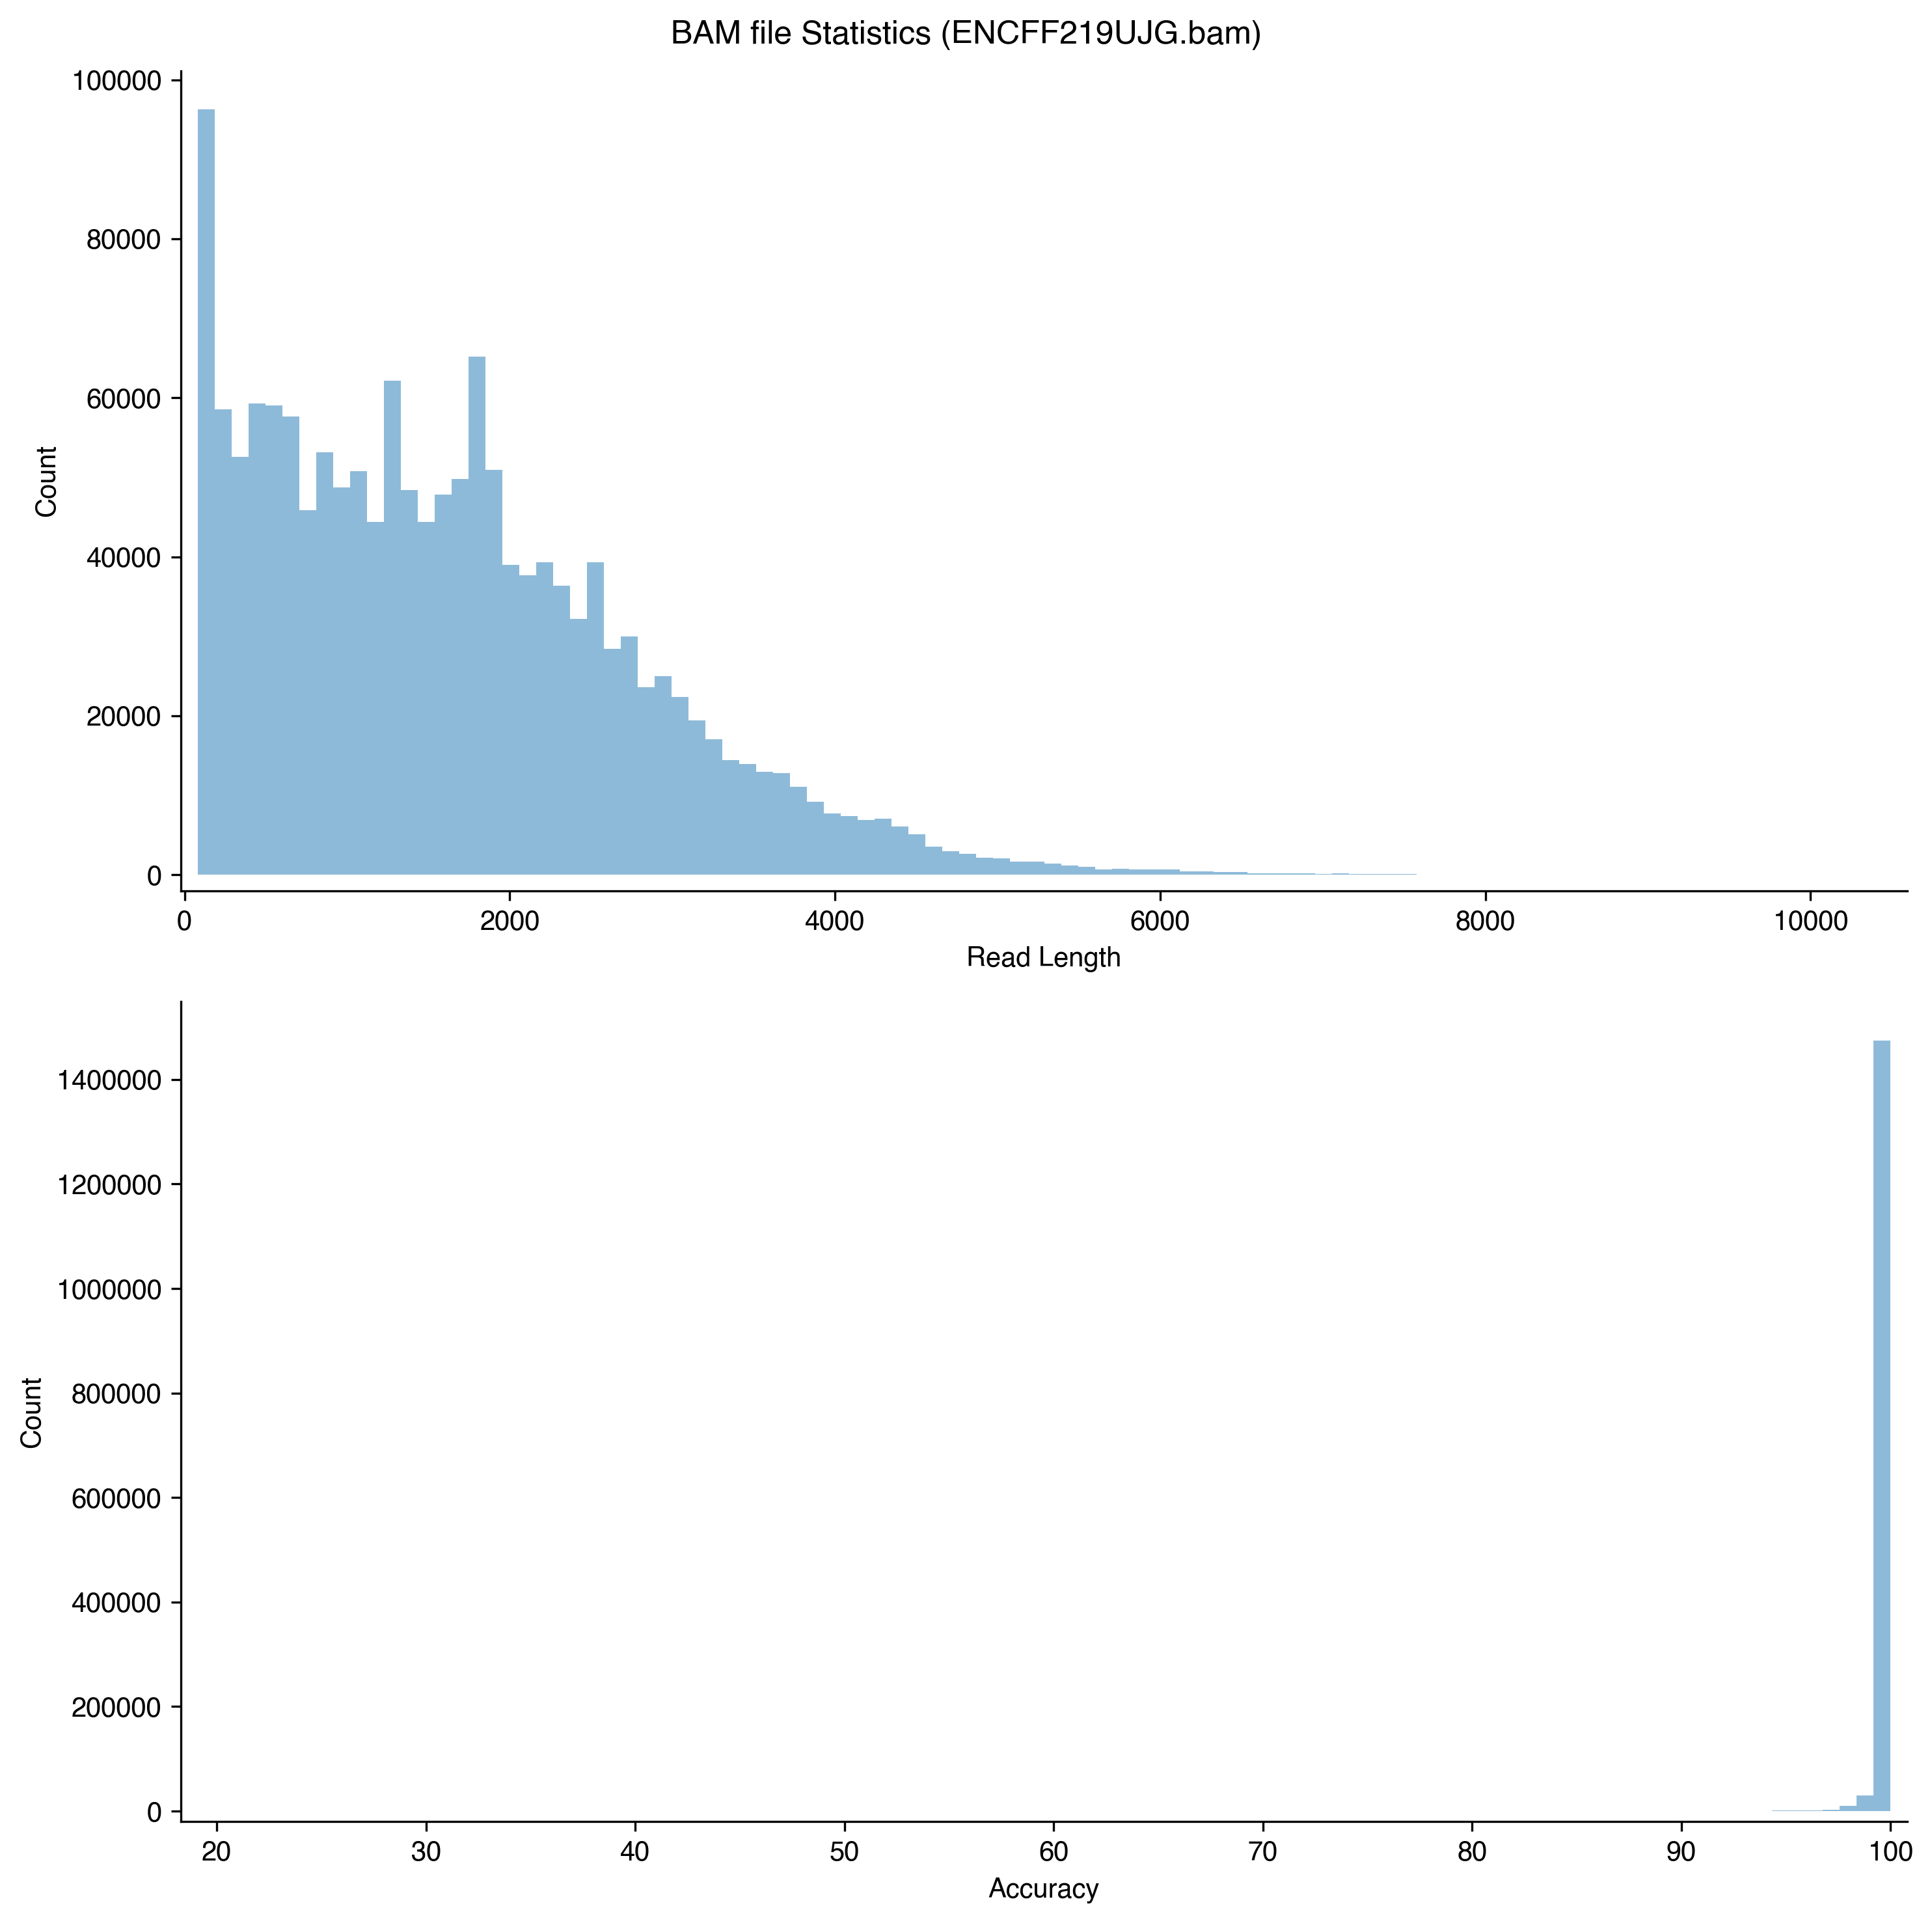

In [7]:
plt.style.use('cowplot')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle('BAM file Statistics (ENCFF219UJG.bam)')
axes[0].hist(stats_df['read_length'], bins=100, alpha=0.5, label='Read Length', color=color_cycle[0])
axes[0].set_xlabel('Read Length')
axes[0].set_ylabel('Count')
axes[1].hist(stats_df['acc'], bins=100, alpha=0.5, label='Read Accuracy', color=color_cycle[0])
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Count')
axes[1].ticklabel_format(style='plain', axis='y')
for axis in axes:
    y_ticks = axis.get_yticks()
    padding = y_ticks[1] * 0.1
    y_lim_min = y_ticks[0] - padding
    axis.set_ylim(bottom=y_lim_min)

plt.show

In [ ]:
display(GetIntronJunctions('ENCFF564ONS.bam', threads=8, max_mismatch_rate=0.05, min_mapq=30))

None

In [8]:
pl.read_csv('golden_standard/downloads/ENCBS020DQC/ENCFF835KGV.introns.tab', separator='\t')

chrom,start,end,strand,reads
str,i64,i64,str,i64
"""chr1""",827775,829002,"""+""",4
"""chr1""",829104,841199,"""+""",6
"""chr1""",827853,829002,"""+""",1
"""chr1""",960800,961628,"""+""",5
"""chr1""",961750,961825,"""+""",16
…,…,…,…,…
"""chrX""",155524632,155545095,"""-""",12
"""chrX""",155545277,155612791,"""-""",12
"""chrX""",155492700,155506897,"""-""",2


In [ ]:
import bioframe as bf

bf.overlap()

TypeError: overlap() missing 2 required positional arguments: 'df1' and 'df2'